
# **Classifieur pour prédire la probabilité de rester 5 ans en NBA**
## Test technique MP DATA - Florian Larab - 03/11/2025

## Objectif
Prédire si un jeune joueur restera en NBA au moins 5 saisons ( traduction : `TARGET_5Yrs = 1`).  
**Exigence métier** : **ne pas rater des talents** -> on priorise le rappel (recall).

## Stratégie globale
1. **Compréhension & risques** : éviter les fuites, gérer les homonymes et étiquettes contradictoires.  
2. **Pré-traitement minimaliste et efficace** : normaliser les pourcentages, clipper les compteurs à ≥0, ajouter des features simples (`PTS/GP`, `PTS/MIN`) et des indicateurs de tentatives (`Has3PA`, `HasFTA`, `HasFGA`).  
3. **Validation** : **CV stratifiée 3-fold** avec métriques **recall**, **precision**, **F2** (beta=2 -> recall 4x plus important), **AUROC** et **Average Precision** (aire PR).  
4. **Sélection de modèle** : **GridSearchCV** sur 4 familles (LogReg, RandomForest, GradientBoosting, SVC RBF) avec des grilles compactes pour un temps d'entrainement raisonnable (je n'ai pas une machine de guerre).  
5. **Seuil de décision** : à partir de la courbe précision–rappel **(OOF)**, on choisit un seuil F2-optimal et un seuil garantissant un rappel cible (ex. >= 0.85) avec la meilleure précision disponible.  
6. **Export** : modèle entraîné sur tout le dataset + seuils .

> **Choix du rappel** Un faux négatif équivaut à rater un futur talent. Dans ce use‑case, l’impact métier d’un FN est plus coûteux qu’un FP (sélectionner un joueur qui ne tiendra pas 5 ans). D’où F2 et les seuils pro‑recall.



## Imports & constantes

- **RANDOM_STATE=42** pour la reproductibilité.  
- `DATA_PATH` pointe sur le CSV fourni.  
- `matplotlib` pour les graphes (courbe PR).


In [1]:

import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix, recall_score, precision_score, fbeta_score, roc_auc_score, average_precision_score, precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
DATA_PATH = Path("nba_logreg.csv")
pd.set_option("display.max_columns", 200)



## Chargement des données & inspection rapide

- On vérifie la forme du dataset et on liste quelques colonnes pour se familiariser avec les donnees.  
- Les colonnes clés incluent des stats de base et la cible : `TARGET_5Yrs`.


In [2]:

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))
print("\nColonnes:", list(df.columns))


Shape: (1340, 21)


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0



Colonnes: ['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs']



## Pré‑traitement : principes et risques gérés

1. **Doublons exacts**(sur toutes les colonnes incluant la target) : suppression directe (`drop_duplicates`).  
2. **Homonymes** : on ne fusionne pas par `Name`
3. **Étiquettes contradictoires** : des lignes avec les mêmes features mais des cibles différentes ->on les supprime (bruit).  
4. **Normalisation des %** : s’assurer que `FG%`, `FT%`, `3P%` sont entre [0,1].  
5. **Non‑négativité** : clip à 0 pour les compteurs** (`GP`, `MIN`, `FGA`, etc.).  
6. **Imputation simple** : `fillna(0.0)` (logique pour “pas tenté”) + flags `Has3PA`, `HasFTA`, `HasFGA` pour éviter d’interpréter un 0 comme une “performance nulle”.  
7. **Features simples** mais utiles : `PTS/GP`, `PTS/MIN`.  

> Ce choix de simplicité favorise la compréhension et la traçabilité pendant le test, sans sacrifier sur les performances du classiefieur.


In [3]:

def safe_div(num, den, default=0.0):
    """Division sûre: retourne 'default' si le dénominateur (den) <=0 ou NaN (évite les Inf/NaN)."""
    num = np.asarray(num); den = np.asarray(den)
    return np.where((den > 0) & np.isfinite(den), num / den, default)

def engineer_and_clean_simple(df: pd.DataFrame) -> pd.DataFrame:
    """
    Nettoyage minimal + features simples :
    - supprime les doublons exacts
    - normalise FG%/FT%/3P% dans [0,1] (si besoin), et clippe ces colonnes
    - clippe les compteurs à >= 0 (GP, MIN, FGA,...)
    - ajoute des indicateurs de tentative: Has3PA/HasFTA/HasFGA
    - ajoute PTS/GP et PTS/MIN (division sûre)
    - impute les NaN restants à 0.0
    """
    df = df.drop_duplicates().copy()

    # # % appartenance à [0,1]
    # for c in ["FG%", "FT%", "3P%"]:
    #     if c in df.columns:
    #         mx = df[c].max(skipna=True)
    #         if pd.notna(mx) and mx > 1.5:
    #             df[c] = df[c] / 100.0  # passe de [0,100] -> [0,1]
    #         df[c] = df[c].clip(0.0, 1.0)

    # Compteurs >= 0
    nonneg = ["GP","MIN","FGM","FGA","3P Made","3PA","FTM","FTA",
              "OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS"]
    for c in nonneg:
        if c in df.columns:
            df[c] = df[c].clip(lower=0)

    # Flags de tentative (structurent l'info) : on extrait un epetite info supplémentaire, la notion de tentative
    if "3PA" in df.columns: df["Has3PA"] = (df["3PA"] > 0).astype(int)
    if "FTA" in df.columns: df["HasFTA"] = (df["FTA"] > 0).astype(int)
    if "FGA" in df.columns: df["HasFGA"] = (df["FGA"] > 0).astype(int)

    # Ratios simples par game et par minute : je cherche à rapporter la performance d'un joueur en temps et en nb de jeux
    if {"PTS","GP"}.issubset(df.columns):  df["PTS/GP"]  = safe_div(df["PTS"], df["GP"])
    if {"PTS","MIN"}.issubset(df.columns): df["PTS/MIN"] = safe_div(df["PTS"], df["MIN"])


    if "GP" in df.columns:
        for c in ["PTS","REB","AST","STL","BLK","TOV","PF"]:
            if c in df.columns:
                df[f"{c}_TOT"] = df[c] * df["GP"]


    return df.fillna(0.0)

def drop_label_conflicts(df: pd.DataFrame, target_col: str = "TARGET_5Yrs", round_decimals: int = 6):
    """
    Supprime toute ligne appartenant à un groupe de features identiques (hors Name)
    dont la target diffère (contradiction 0/1 au sein du même X).
    - On arrondit les colonnes numériques pour éviter les faux positifs (flottants).
    - Retourne (df_sans_conflits, nb_lignes_supprimées).
    """
    assert target_col in df.columns, f"Target column '{target_col}' missing."
    features = [c for c in df.columns if c not in [target_col, "Name"]]

    df_r = df.copy()
    num_cols = df_r[features].select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        df_r.loc[:, num_cols] = df_r.loc[:, num_cols].round(round_decimals)

    conflict_mask = df_r.groupby(features)[target_col].transform("nunique") > 1
    n_drop = int(conflict_mask.sum())
    df_out = df.loc[~conflict_mask].reset_index(drop=True)
    return df_out, n_drop

def make_X_y(df: pd.DataFrame, target_col: str = "TARGET_5Yrs"):
    """Séparation X/y en retirant la target (et 'Name' si présent)."""
    assert target_col in df.columns, f"Target column '{target_col}' missing."
    y = df[target_col].astype(int)
    X = df.drop(columns=[target_col, "Name"], errors="ignore").copy()
    return X, y



## Exécution du prétraitement

- On applique `engineer_and_clean_simple`.  
- On supprime les étiquettes contradictoires.  
- On sépare **X** (features) et **y** (ntore target).


In [4]:

df = engineer_and_clean_simple(df)
df, n_conflicts = drop_label_conflicts(df, target_col="TARGET_5Yrs", round_decimals=6)
print(f"Étiquettes contradictoires supprimées : {n_conflicts}")
X, y = make_X_y(df, target_col="TARGET_5Yrs")
print("Shapes → df:", df.shape, "| X:", X.shape, "| y:", y.shape)


Étiquettes contradictoires supprimées : 40
Shapes → df: (1288, 32) | X: (1288, 30) | y: (1288,)


## Balance des classes
Les classes sont plutôt équilibrées. On garde cette hypothèse pour la suite.

Samples: 1288 | Positives (1): 804 | Negatives (0): 484 | Positive ratio: 0.624


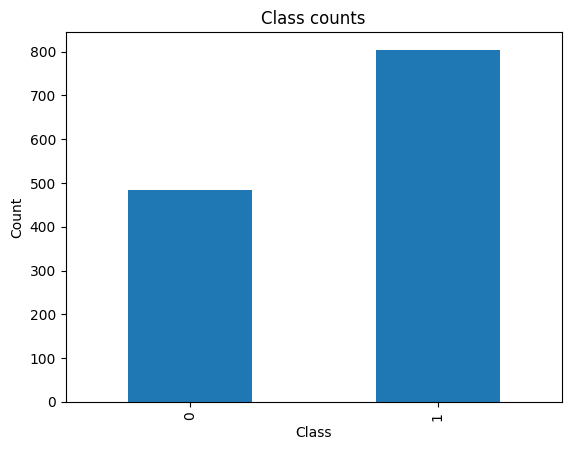

In [5]:
n = len(df)
pos = int(y.sum())
neg = n - pos
print(f"Samples: {n} | Positives (1): {pos} | Negatives (0): {neg} | Positive ratio: {pos/n:.3f}")

counts = pd.Series({"0": neg, "1": pos})
plt.figure()
counts.plot(kind="bar")
plt.title("Class counts")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


## Validation et métriques : explications 
- **CV stratifiée (3-fold)** : équilibre la proportion de `TARGET_5Yrs=1` dans chaque fold.  
- **Métriques suivies** :
  - **Recall** = TP / (TP + FN) : priorité absolue: ne pas rater de talents.  
  - **Precision** = TP / (TP + FP) :confiance des “positifs” proposés.  
  - **F2** (beta=2) : combine P & R en donnant 4 fois plus de poids au recall.  
  - **AUROC** : qualité de ranking globale.  
  - **Average Precision** : aire sous la courbe précision–rappel (plus informative quand les classes sont déséquilibrées).




## Modèles testés et grilles utilisées

- **LogisticRegression** : baseline linéaire, interprétable.  
- **RandomForest** : non‑linéaire, robuste,  
- **GradientBoosting** : précis et assez ancien : simple.  
- **SVC RBF (probability=True)** : donne une probabilité.

> Grilles compactes pour rester dans un temps d’exécution raisonnable pendant le test.


In [6]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def build_preprocess(X):
    numeric_features = X.columns.tolist()
    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
                ("scaler", StandardScaler()),
            ]), numeric_features)
        ]
    )
    return preprocess

def make_model_spaces(X, random_state=RANDOM_STATE):
    preprocess = build_preprocess(X)

    # 1) Régression logistique
    logreg = Pipeline([
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=5000, class_weight="balanced",  # on a vu que les classes sont plutot équilibrées
                                     solver="lbfgs", random_state=random_state))
    ])
    logreg_grid = {"model__C": [0.3, 1.0, 3.0]}

    # 2) Random Forest
    rf = Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(n_estimators=300, class_weight="balanced",
                                         random_state=random_state, n_jobs=-1))
    ])
    rf_grid = {
        "model__n_estimators": [200, 300],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": [1, 3],
        "model__max_features": ["sqrt", 0.5],
    }

    # 3) Gradient Boosting
    gb = Pipeline([
        ("prep", preprocess),
        ("model", GradientBoostingClassifier(random_state=random_state))
    ])
    gb_grid = {
        "model__n_estimators": [150, 300],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [1.0, 0.8],
    }

    # 4) SVC RBF (probabilités activées)
    svc = Pipeline([
        ("prep", preprocess),
        ("model", SVC(kernel="rbf", probability=True, class_weight="balanced",
                      random_state=random_state))
    ])
    svc_grid = {"model__C": [0.5, 1.0, 2.0], "model__gamma": ["scale", "auto"]}

    return {"LogReg": (logreg, logreg_grid),
            "RF": (rf, rf_grid),
            "GB": (gb, gb_grid),
            "SVC_RBF": (svc, svc_grid)}



## GridSearch multi‑métriques puis sélection par recall (ou F2 possible aussi)

- On refit automatiquement selon la métrique de référence (`refit_metric`).  
- On construit un leaderboar clair pour comparer les familles de modèles.


In [7]:

from sklearn.metrics import make_scorer

SCORERS = {
    "recall":    make_scorer(recall_score),
    "precision": make_scorer(precision_score),
    "f2":        make_scorer(fbeta_score, beta=2),
}

def run_model_sweep(X, y, spaces, scorers=SCORERS, refit_metric="recall",
                    n_splits=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=0):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows, best = [], {"name": None, "estimator": None, "score": -np.inf}

    for name, (estimator, grid) in spaces.items():
        gs = GridSearchCV(estimator=estimator, param_grid=grid, scoring=scorers,
                          refit=refit_metric, cv=cv, n_jobs=n_jobs, verbose=verbose,
                          return_train_score=False)
        gs.fit(X, y)

        res = gs.cv_results_; bi = gs.best_index_
        rows.append({
            "model": name,
            "best_params": gs.best_params_,
            "mean_recall":    float(res["mean_test_recall"][bi]),
            "mean_precision": float(res["mean_test_precision"][bi]),
            "mean_f2":        float(res["mean_test_f2"][bi]),
        })

        metric_key = f"mean_test_{refit_metric}"
        score_here = float(res[metric_key][bi])
        if score_here > best["score"]:
            best.update({"name": name, "estimator": gs.best_estimator_, "score": score_here})

    leaderboard = pd.DataFrame(rows).sort_values(
        by={"recall":"mean_recall","precision":"mean_precision","f2":"mean_f2"}[refit_metric],
        ascending=False).reset_index(drop=True)
    return best["name"], best["estimator"], leaderboard

spaces = make_model_spaces(X, random_state=RANDOM_STATE)

REFIT_METRIC = "recall"  # mettre "f2" si l'on veut officiellement pondérer le recall
best_name, best_estimator, leaderboard = run_model_sweep(
    X, y, spaces, refit_metric=REFIT_METRIC, n_splits=3, n_jobs=-1, verbose=0
)
display(leaderboard)
print(f"Meilleur modèle selon {REFIT_METRIC} :", best_name)


,model,best_params,mean_recall,mean_precision,mean_f2
0,RF,"{'model__max_depth': 20, 'model__max_features'...",0.810945,0.740173,0.795420
1,GB,"{'model__learning_rate': 0.05, 'model__max_dep...",0.805970,0.740635,0.791558
2,LogReg,{'model__C': 0.3},0.661692,0.801378,0.684902
3,SVC_RBF,"{'model__C': 0.5, 'model__gamma': 'scale'}",0.646766,0.806369,0.672972


Meilleur modèle selon recall : RF



## Evaluation CV du modèle sélectionné

On calcule sur 3 folds :
- Matrice de confusion cumulée.  
- Recall, Precision, AUROC, Average Precision.


In [8]:

def score_classifier_extra(X, y, estimator, n_splits=3, seed=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cm = np.zeros((2,2), dtype=int)
    recalls, precisions, aucs, aps = [], [], [], []
    for tr, te in skf.split(X, y):
        est = estimator
        est.fit(X.iloc[tr], y.iloc[tr])
        yhat = est.predict(X.iloc[te])
        cm += confusion_matrix(y.iloc[te], yhat, labels=[0,1])
        recalls.append(recall_score(y.iloc[te], yhat))
        precisions.append(precision_score(y.iloc[te], yhat))
        # Probas pour AUROC/AP
        if hasattr(est, "predict_proba"):
            p = est.predict_proba(X.iloc[te])[:,1]
        elif hasattr(est, "decision_function"):
            p = est.decision_function(X.iloc[te])
        else:
            p = yhat  # fallback, peu informatif
        aucs.append(roc_auc_score(y.iloc[te], p))
        aps.append(average_precision_score(y.iloc[te], p))
    return cm, float(np.mean(recalls)), float(np.mean(precisions)), float(np.mean(aucs)), float(np.mean(aps))

cm_cv, recall_cv, precision_cv, auroc_cv, ap_cv = score_classifier_extra(X, y, best_estimator, n_splits=3)
print("Matrice de confusion (somme sur folds) [rows=true, cols=pred]:\n", cm_cv)
print("Mean recall:", recall_cv)
print("Mean precision:", precision_cv)
print("Mean AUROC:", auroc_cv)
print("Mean Average Precision (PR AUC):", ap_cv)


Matrice de confusion (somme sur folds) [rows=true, cols=pred]:
 [[254 230]
 [152 652]]
Mean recall: 0.8109452736318409
Mean precision: 0.740172851673553
Mean AUROC: 0.7425687632308513
Mean Average Precision (PR AUC): 0.8227739492097251



## Courbe précision–rappel (OOF) & choix de seuil

- On produit des probabilités OOF (out of fold) pour éviter l’optimisme.  
- On trace la PR curve et on calcule :
  1. Seuil F2‑optimal : maximise (F_beta) avec (beta=2).  
  2. seuil à rappel cible (ex. >= 0.85) : parmi les seuils atteignant ce rappel, on prend celui qui a la meilleure précision.

Formule :  
F_beta = (1+beta^2) * v(P * R)/(beta^2 *P + R) ; beta=2 
->Rappel 4fois plus important que  la précision

> En prod, on applique ce seuil à la proba positive pour décider 0/1.  
> Levier métier : on peut exposer ce seuil comme un paramètre (mode “recall”, “balanced”, “precision”).


Average Precision (aire PR): 0.8210
F2 optimal: 0.8927 @ threshold=0.0650
Recall≥0.85: threshold=0.4551, precision=0.7185, recall=0.8507


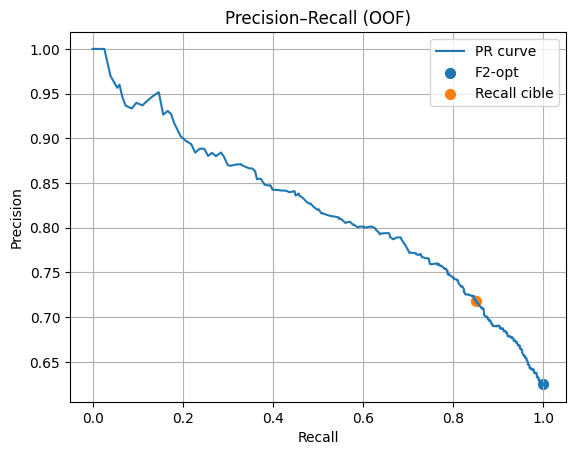

Seuils sauvegardés dans: thresholds_final.json


In [9]:

BETA = 2.0
TARGET_RECALL = 0.85

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
oof_proba = np.zeros(len(y), dtype=float)

for tr_idx, te_idx in skf.split(X, y):
    est = best_estimator
    est.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    if hasattr(est, "predict_proba"):
        oof_proba[te_idx] = est.predict_proba(X.iloc[te_idx])[:, 1]
    elif hasattr(est, "decision_function"):
        scores = est.decision_function(X.iloc[te_idx])
        smin, smax = scores.min(), scores.max()
        oof_proba[te_idx] = (scores - smin) / (smax - smin + 1e-12)
    else:
        oof_proba[te_idx] = 0.5  # fallback neutre

prec, rec, thr = precision_recall_curve(y, oof_proba)
ap = average_precision_score(y, oof_proba)
print(f"Average Precision (aire PR): {ap:.4f}")

# F-beta optimal
eps = 1e-12
f_beta = (1 + BETA**2) * (prec * rec) / (BETA**2 * prec + rec + eps)
thr_aligned = np.r_[thr, 1.0]  # aligne longueurs
best_idx = int(np.nanargmax(f_beta))
BEST_F2 = float(f_beta[best_idx]); BEST_F2_THRESHOLD = float(thr_aligned[best_idx])

# Seuil de rappel cible
mask = rec >= TARGET_RECALL
if np.any(mask):
    idxs = np.where(mask)[0]
    tr_idx = idxs[np.argmax(prec[idxs])]
    TARGET_RECALL_THRESHOLD = float(thr_aligned[tr_idx])
    TR_PREC, TR_REC = float(prec[tr_idx]), float(rec[tr_idx])
else:
    TARGET_RECALL_THRESHOLD = None
    TR_PREC = None; TR_REC = None

print(f"F2 optimal: {BEST_F2:.4f} @ threshold={BEST_F2_THRESHOLD:.4f}")
if TARGET_RECALL_THRESHOLD is not None:
    print(f"Recall≥{TARGET_RECALL:.2f}: threshold={TARGET_RECALL_THRESHOLD:.4f}, precision={TR_PREC:.4f}, recall={TR_REC:.4f}")
else:
    print(f"Recall≥{TARGET_RECALL:.2f} non atteignable: améliorer le modèle ou baisser la cible.")

# PR curve
plt.figure()
plt.plot(rec, prec, label="PR curve")
plt.scatter(rec[best_idx], prec[best_idx], label="F2-opt", s=50)
if TARGET_RECALL_THRESHOLD is not None:
    plt.scatter(TR_REC, TR_PREC, label="Recall cible", s=50)
plt.title("Precision–Recall (OOF)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

# Sauvegarde des seuils (pour l'API)
THRESHOLDS_PATH = Path("thresholds_final.json")
with THRESHOLDS_PATH.open("w") as f:
    json.dump({
        "beta": BETA,
        "best_fbeta_threshold": BEST_F2_THRESHOLD,
        "target_recall": TARGET_RECALL,
        "target_recall_threshold": TARGET_RECALL_THRESHOLD,
        "average_precision": float(ap)
    }, f, indent=2)
print("Seuils sauvegardés dans:", THRESHOLDS_PATH)



## Export du modèle et reproductibilité

- On refit le meilleur pipeline sur toutes les données.  
- On sérialise un bundle: `pipeline` + `feature_names`.  
- Reproductibilité garantie par `RANDOM_STATE` et des transformations déterministes.


In [10]:

import joblib

best_estimator.fit(X, y)
MODEL_PATH = Path("model_final.joblib")
joblib.dump({"pipeline": best_estimator, "feature_names": X.columns.tolist()}, MODEL_PATH)
print("Modèle sauvegardé:", MODEL_PATH)


Modèle sauvegardé: model_final.joblib



## Limites et pistes d’améliorations


- Enrichissement de features calculer les données par 36 min (durée d'un match de NBA en général), chercher d'autres features (analyse de corrélation).  
- Analyse d’erreurs : regarder quelles catégories de joueurs génèrent des FN/FP et itérer ciblé.
